# Set up

In [1]:
import sys
sys.path.insert(0, '..')
from libs.dataloaders import mahnob, deap, dreamer
from libs.utils import finetuning
import torch

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-vmbd7g2v because the default path (/home/dutruong/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

from libs.dataloaders import mahnob, deap, dreamer
from joblib import Parallel, delayed
import xml.etree.ElementTree as ET

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import normalize
from torch.utils.tensorboard import SummaryWriter

import pickle

In [3]:
def get_sessions_subjs():
    path = "/net2/expData/affective_eeg/mahnob_dataset/Sessions"
    sessions = os.listdir(path)
    subjs = {}
    scores = {}
    for session in sessions:
        mytree = ET.parse(f'{path}/{session}/session.xml')
        myroot = mytree.getroot()
        if myroot[0].attrib['id'] not in subjs:
            subjs[myroot[0].attrib['id']] = []
        if 'feltVlnc' in myroot.attrib:
            subjs[myroot[0].attrib['id']].append(session)
            scores[session] = int(myroot.attrib['feltVlnc'])
    return subjs, scores

In [4]:
def subject_cv(dataset, subject_sessions:list, models:list, sweep_pc=False, checkpoint=None):
    """
    Run leave one subject out cross-validation using `model`
    Notes:
        - Does _not_ enforce train data balancing, but sets equal priors (assumes data is roughly balanced)
        - Enforce test data; skip fold when per-label count < 3
    @param dataset - dataset
    @param list[list] subject_sessions - sessions binned by subject for leave one subject out
    @param list models - model to use for training; this should be the class, not the instance
    @param bool sweep_pc - sweep the number of PCs
    """
    n_pc_range = np.arange(1, min(len(dataset), len(dataset[0][0][0])+1)) if sweep_pc else np.array([30,]) # min of S and F if sweep enabled
    accs = np.empty((len(subject_sessions), len(models), len(n_pc_range))) # n_subjects -> n_models -> n_pc
    accs[:] = np.nan
    train_accs = accs.copy()
    evs = np.empty((len(subject_sessions), len(models), len(n_pc_range)))
    evs[:] = np.nan
    
    for n_subject, sessions in enumerate(tqdm(subject_sessions.values())):
        train_data = [dataset[i] for i in range(len(dataset)) if dataset.sessions[i] not in sessions]
        test_data = [dataset[i] for i in range(len(dataset)) if dataset.sessions[i] in sessions]
        
        target_model = finetuning.Finetuning(model="AETransformer", n_freezelayers=0, model_params={'checkpoint': checkpoint})  
        input_transform = lambda x, y: target_model._input_augment_fn(x, y)
        X_train_vgg = np.array([target_model.model(input_transform(i[0], i[1])[0]).numpy(force=True).flatten() for i in train_data])
        Y_train_vgg = np.squeeze([i[1] for i in train_data])*2-1 # rescale to -1, 1
        X_test_vgg = np.array([target_model.model(input_transform(i[0], i[1])[0]).numpy(force=True).flatten() for i in test_data])
        Y_test_vgg = np.squeeze([i[1] for i in test_data])*2-1 # rescale to -1, 1

        if len(Y_train_vgg) == 0 or len(Y_test_vgg) == 0:
            print("Skipping: Y train or Y test having no values")
            continue
        if len(np.unique(Y_test_vgg, return_counts=True)[-1]) != len(np.unique(Y_train_vgg, return_counts=True)[-1]):
            print("Skipping: num classes not being equivalent in train and test")
            continue

        # # This really only works for 2 classes; balance
        # u_val, u_count = np.unique(Y_test_vgg, return_counts=True)
        # u_count = list(u_count)
        # if len(u_count) != 2:
        #     print("Skipping: class count is not exactly 2")
        #     continue
        # if u_count[0] != u_count[1]:
        #     # balance the classes to the smaller value
        #     u_reduce = u_val[u_count.index(max(u_count))]
        #     u_reduce_count = abs(u_count[0] - u_count[1])
        #     match_idxs = np.argwhere(Y_test_vgg == u_reduce).squeeze()
        #     np.random.shuffle(match_idxs)
        #     remove_idxs = match_idxs[:u_reduce_count]
        #     keep_idxs = [i for i in range(len(Y_test_vgg)) if i not in remove_idxs]
        #     X_test_vgg = X_test_vgg[keep_idxs]
        #     Y_test_vgg = Y_test_vgg[keep_idxs]
        
        if min(np.unique(Y_test_vgg, return_counts=True)[-1]) < 3:
            print("Skipping: fewer than 3 samples per class detected")
            continue

        # Shuffle train
        shuffle = np.arange(X_train_vgg.shape[0])
        np.random.shuffle(shuffle)
        X_train_vgg = X_train_vgg[shuffle]
        Y_train_vgg = Y_train_vgg[shuffle]
        
        for n_model, model in enumerate(models):
            pca = PCA() # compute full pc
            pca.fit(X_train_vgg)
            X_train_pc = pca.transform(X_train_vgg)
            X_test_pc = pca.transform(X_test_vgg)
            ev_idxs = [i for i in (n_pc_range-1) if i < len(X_train_pc)]
            evs[n_subject, n_model, :len(ev_idxs)] = pca.explained_variance_ratio_[ev_idxs]
            for n_npc, npc in enumerate(n_pc_range):
                model_inst = model()
                model_inst.fit(X_train_pc[:,:npc], Y_train_vgg)
                model_train = model_inst.score(X_train_pc[:,:npc], Y_train_vgg)
                model_test = model_inst.score(X_test_pc[:,:npc], Y_test_vgg)
                
                accs[n_subject, n_model, n_npc] = model_test
                train_accs[n_subject, n_model, n_npc] = model_train
    return accs, evs, train_accs



In [5]:
def per_subject_cv(dataset, subject_sessions:list, model:list, n_jobs=12, checkpoint=None):
    """
    Run per subject validation using `model`
    Notes:
        - Does _not_ enforce train data balancing, but sets equal priors (assumes data is roughly balanced)
        - Enforce test data; skip fold when per-label count < 3
    @param dataset - DEAP dataset
    @param list subject_sessions - subjects or sessions; used for LOO
    @param fn model - model to use for training; this should be the class, not the instance
    @param int n_jobs - number of parallel jobs to run
    """
    dataset_seqs = len(dataset)
    dataset_feats = np.prod(np.shape(dataset[0][0][0]))
    pc_sweep_list = np.arange(1, min(dataset_seqs, dataset_feats+1))
    
    def _thread_worker(session, k_bootstrap, npc, X_train_pc, Y_train_vgg, X_test_pc, Y_test_vgg):
        def default_return(msg=""):
            return (session, k_bootstrap, npc), msg

        if len(Y_train_vgg) == 0 or len(Y_test_vgg) == 0:
            return default_return("Skipping: Y train or Y test having no values")
        
        unique_info = np.unique(Y_train_vgg, return_counts=True)
        if len(unique_info[0]) != 2:
            return default_return(f"Skipping: exactly 2 classes not detected")
        if min(unique_info[-1]) < 3:
            return default_return("Skipping: fewer than 3 samples per class detected")

        model_inst = model()
        model_inst.fit(X_train_pc[:,:npc], Y_train_vgg)
        model_train = model_inst.score(X_train_pc[:,:npc], Y_train_vgg)
        model_test = model_inst.score(X_test_pc[:,:npc], Y_test_vgg)

        return (session, k_bootstrap, npc), (pca.explained_variance_ratio_, model_train, model_test)

    # Generate parameter set of parallelization
    results = []
    for session in tqdm(subject_sessions):
        data_idx = [i for i in range(len(dataset)) if dataset.sessions[i] == session]
        job_list = []
        for k_bootstrap, test_idx in enumerate(tqdm(data_idx)):
            train_idx = [i for i in data_idx if i != test_idx]
            train_data = [dataset[i] for i in train_idx]
            
            target_model = finetuning.Finetuning(model="AETransformer", n_freezelayers=0, model_params={'checkpoint': checkpoint}) # changed  
            input_transform = lambda x, y: target_model._input_augment_fn(x, y)
            X_train_vgg = np.array([target_model.model(input_transform(i[0], i[1])[0].unsqueeze(0)).numpy(force=True).flatten() for i in train_data]) # changed
            Y_train_vgg = np.squeeze([i[1] for i in train_data])*2-1 # rescale to -1, 1
            X_test_vgg = np.array([target_model.model(input_transform(dataset[test_idx][0], dataset[test_idx][1])[0].unsqueeze(0)).numpy(force=True).flatten(),])
            Y_test_vgg = np.squeeze(dataset[test_idx][1])*2-1 # rescale to -1, 1
            if len(np.shape(Y_train_vgg)) == 0:
                Y_train_vgg = np.expand_dims(Y_train_vgg, axis=0)
            if len(np.shape(Y_test_vgg)) == 0:
                Y_test_vgg = np.expand_dims(Y_test_vgg, axis=0)
            
            # Shuffle train
            shuffle = np.random.permutation(np.arange(X_train_vgg.shape[0]))
            X_train_vgg = X_train_vgg[shuffle]
            Y_train_vgg = Y_train_vgg[shuffle]

            # Fit PC
            pca = PCA() # compute full pc
            pca.fit(X_train_vgg)
            X_train_pc = pca.transform(X_train_vgg)
            X_test_pc = pca.transform(X_test_vgg)
            
            job_list.extend([
                (session, k_bootstrap, npc, 
                    X_train_pc, Y_train_vgg, X_test_pc, Y_test_vgg,
                ) for npc in pc_sweep_list])
        
        # Run model computations
        # partial_results = [_thread_worker(*job) for job in tqdm(job_list)]
        partial_results = Parallel(n_jobs=n_jobs, backend="threading", verbose=1)(delayed(_thread_worker)(*job) for job in job_list)
        results.extend(partial_results)

    # Results objects
    train_accs = np.empty((len(subject_sessions), len(pc_sweep_list), max(np.unique(dataset.sessions, return_counts=True)[1]))) # n_subjects -> n_pc -> bootstrap
    train_accs[:] = np.nan
    test_accs = train_accs.copy()
    evs = np.empty((len(subject_sessions), max(pc_sweep_list))) # n_subjects -> max(pc_list)
    evs[:] = np.nan

    # Consolidate results
    for n_session, session in enumerate(subject_sessions):
        session_result = [i for i in results if i[0][0] == session]
        max_npc = max(pc_sweep_list)
        for n_npc, npc in enumerate(pc_sweep_list):
            npc_result = [i for i in session_result if i[0][2] == npc]
            for k_bootstrap in npc_result:
                if type(k_bootstrap[1]) is not str:
                    train_accs[n_session, n_npc, k_bootstrap[0][1]] = k_bootstrap[1][1]
                    test_accs[n_session, n_npc, k_bootstrap[0][1]] = k_bootstrap[1][2]
                    if npc == max_npc:
                        # across bootstraps values should be near identical
                        evs[n_session, :len(k_bootstrap[1][0])] = k_bootstrap[1][0]
    
    return train_accs, test_accs, evs

In [7]:
def trainmax2test(train, test):
    '''subject pc bootstrap -> subject bootstrap'''
    ## Max with fewest nPC
    # _train = np.nanmean(train, axis=2) # avg on bootstrap
    # _train = np.nan_to_num(_train, nan=-1.) # hacky way to get around all nan argmax
    # _argmax = np.argmax(_train, axis=1) # find max acc per pc
    # return np.array([subj[_argmax[n_subj], :] for n_subj, subj in enumerate(test)])

    ## Max with most nPC
    # _train = np.nanmean(train, axis=2) # avg on bootstrap
    # _train = np.nan_to_num(_train, nan=-1.) # hacky way to get around all nan argmax
    # _train = np.flip(_train, axis=1)
    # _argmax = np.argmax(_train, axis=1) # find max acc per pc
    # _test = np.flip(test, axis=1)
    # _test = np.array([subj[_argmax[n_subj], :] for n_subj, subj in enumerate(_test)])
    # _test = np.flip(_test, axis=1)
    # return _test

    ## Max with most nPC
    _train = np.nan_to_num(train, nan=-1.) # hacky way to get around all nan argmax
    _train = np.flip(_train, axis=1)
    _argmax = np.argmax(_train, axis=1) # find max acc per pc
    _test = np.flip(test, axis=1)
    return np.array([[k[_argmax[n_subj, n_k]] for n_k, k in enumerate(subj.T)] for n_subj, subj in enumerate(_test)])

def plot_overview(train, test, ev, dataset=None, dataset_clip=10):
    mdl_accs = trainmax2test(train, test)

    if dataset is not None:
        print(f"Clipping datasets with fewer than {dataset_clip} samples...")
        valid_sessions_idx = np.argwhere(np.unique(dataset.sessions, return_counts=True)[1] >= 10).squeeze()
    else:
        valid_sessions_idx = np.arange(mdl_accs.shape[0])
    
    mdl_accs = mdl_accs[valid_sessions_idx,:]
    mdl_means = np.nanmean(mdl_accs, axis=1) # avg on bootstrap
    print(np.nanmean(mdl_means))
    mdl_stderr = np.nanstd(mdl_accs, axis=1) / np.sqrt(np.count_nonzero(~np.isnan(mdl_accs), axis=1))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.ylabel("Accuracy")

    plt.subplot(2,1,2)
    plt.plot(np.cumsum(ev, axis=-1).T)
    plt.xlabel("Subject")
    plt.ylabel("Exp Var")
    plt.show()

In [8]:
import torch
import torchvision.models as torchmodels
def vgg16_augment(model):
    model.classifier = torch.nn.Sequential(*list(model.classifier.children())[:-3])
def inception_augment(model):
    model = torch.nn.Sequential(*list(torchmodels.inception_v3(weights="DEFAULT").children())[:-3])

# Mahnob Topomap

In [ ]:
with open('mahnob.pkl', 'rb') as fin:
    dataset = pickle.load(fin)
    dataset = dataset['dataset']
target_model = finetuning.Finetuning(model="AE", n_freezelayers=0, model_params={'checkpoint': '/home/jovyan/deep-eeg/notebooks/AE_mahnob_topomap_adamax_epoch500_seed9'})  
sample, label = target_model._input_augment_fn(dataset[18][0], dataset[0][1])
recons = target_model.model(sample)
# recons -= recons.min(1, keepdim=True)[0]
# recons /= recons.max(1, keepdim=True)[0]
recons = torch.squeeze(recons).transpose(0,2)
# recons.shape
print(recons.max())
plt.imshow(np.uint16(recons.numpy(force=True)))

In [ ]:
target_model = finetuning.Finetuning(model="AE", n_freezelayers=0, model_params={'checkpoint': '/home/jovyan/deep-eeg/notebooks/AE_mahnob_topomap_adamax_epoch350'})  
sample, label = target_model._input_augment_fn(dataset[18][0], dataset[0][1])
sample = torch.squeeze(sample).transpose(0,2)
# sample -= sample.min(1, keepdim=True)[0]
# sample /= sample.max(1, keepdim=True)[0]
print(sample.max())
plt.imshow(np.uint16(sample.numpy(force=True)))

In [ ]:
# Train AE
with open('mahnob.pkl', 'rb') as fin:
    dataset = pickle.load(fin)
    dataset = dataset['dataset']
target_model = finetuning.Finetuning(model="AE", n_freezelayers=0, model_params={'checkpoint': '/home/jovyan/deep-eeg/notebooks/AE_mahnob_topomap_adamax_epoch350'}, seed=4)  
sum_params = 0
for param in target_model.model.parameters():
    sum_params += torch.sum(param)
print(sum_params)

lr = 0.001
optimizer = torch.optim.Adamax(target_model.model.parameters(), lr = lr)
target_model.train(dataset, log_dir='./runs/mahnob/topomap/AEadamax/epoch500/seed4', optimizer=optimizer, lr=lr, epochs=150, early_stopping_eps=0.0001, lr_decay_nepoch=100)
torch.save(target_model.model.state_dict(), 'AE_mahnob_topomap_adamax_epoch500_seed4')

In [ ]:
with open('mahnob.pkl', 'rb') as fin:
    dataset = pickle.load(fin)
    dataset = dataset['dataset']
subjects, subject_scores = get_sessions_subjs()
acc, evs, train_acc  = subject_cv(dataset, subjects, models, sweep_pc=True, checkpoint='/home/jovyan/deep-eeg/notebooks/AE_mahnob_topomap_adamax_epoch500_seed9')
print('train mean', np.mean(train_acc))
print('test mean', np.mean(acc))

with open("result_finetune_mahnob_topomap_AE_unbalanced.pkl", "wb") as fout:
    pickle.dump({"acc": acc, 
                 "train_acc": train_acc,
                 "ev": evs, "models": models}, fout)

In [ ]:
for n_model, model in enumerate(models):
    mdl_acc = acc[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.cumsum(evs[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

# Mahnob Spectrogram

In [ ]:
seed = 9
with open('mahnob_spectrogram.pkl', 'rb') as fin:
    dataset = pickle.load(fin)
    dataset = dataset['dataset']
target_model = finetuning.Finetuning(model="AE", n_freezelayers=0, seed=seed)  
sum_params = 0
for param in target_model.model.parameters():
    sum_params += torch.sum(param)
print(sum_params)

lr = 0.001
optimizer = torch.optim.Adamax(target_model.model.parameters(), lr = lr)
target_model.train(dataset, log_dir='./runs/mahnob/specto/AEAdamax/epoch500/seed'+str(seed), optimizer=optimizer, lr=lr, epochs=500, early_stopping_eps=0.000001, lr_decay_nepoch=100)
torch.save(target_model.model.state_dict(), 'AE_mahnob_specto_adamax_epoch500_seed'+str(seed))

tensor(-74804.7891, grad_fn=<AddBackward0>)
tensor(-74804.7891, grad_fn=<AddBackward0>)
tensor(-74804.7969, device='cuda:0', grad_fn=<AddBackward0>)
epoch 0:
loss=0.006520733789945341
weights=-141016.921875

epoch 1:
loss=0.005795251005423265
weights=-144579.09375

epoch 2:
loss=0.005747887796858758
weights=-150476.203125

epoch 3:
loss=0.005714346190227779
weights=-157769.734375

epoch 4:
loss=0.005697883656154377
weights=-163548.21875

epoch 5:
loss=0.005690327546832086
weights=-169499.421875

epoch 6:
loss=0.0056724931863653995
weights=-172892.921875

epoch 7:
loss=0.005597997814266368
weights=-176444.265625

epoch 8:
loss=0.005441905771302191
weights=-181036.078125

epoch 9:
loss=0.005442650844648744
weights=-186722.828125

epoch 10:
loss=0.005430914633295903
weights=-191392.125

epoch 11:
loss=0.005424353787369763
weights=-196429.953125

epoch 12:
loss=0.005417377486909655
weights=-201004.6875

epoch 13:
loss=0.00540910755587516
weights=-205798.046875

epoch 14:
loss=0.00540381236

In [ ]:
with open('mahnob_spectrogram.pkl', 'rb') as fin:
    dataset = pickle.load(fin)
    dataset = dataset['dataset']
subjects, subject_scores = get_sessions_subjs()
acc, evs, train_acc  = subject_cv(dataset, subjects, models, sweep_pc=True, checkpoint='/home/jovyan/deep-eeg/notebooks/checkpoints/mahnob/specto/AEAdamax/seed9/epoch_160')
print('train mean', np.mean(train_acc))
print('test mean', np.mean(acc))

with open("result_finetune_mahnob_specto_AE_unbalanced.pkl", "wb") as fout:
    pickle.dump({"acc": acc, 
                 "train_acc": train_acc,
                 "ev": evs, "models": models}, fout)

In [ ]:
for n_model, model in enumerate(models):
    mdl_acc = acc[:,n_model,:]
    mdl_means = np.nanmean(mdl_acc, axis=0)
    mdl_stderr = np.nanstd(mdl_acc, axis=0) / np.sqrt(len(mdl_means))
    
    plt.subplot(2,1,1)
    plt.errorbar(np.arange(len(mdl_means)), mdl_means, yerr=mdl_stderr, color='k', ecolor="grey")
    plt.title(f"{str(model.func).split('.')[-1][:-2]}")
    plt.ylabel("Accuracy")
    
    plt.subplot(2,1,2)
    plt.plot(np.cumsum(evs[:,n_model,:], axis=-1).T)
    plt.xlabel("# PCs")
    plt.ylabel("Exp Var")
    plt.show()

# Deap Topomap

In [3]:
seed = 7
# Train AE
with open('deap_topomap.pkl', 'rb') as fin:
    dataset = pickle.load(fin)
    dataset = dataset['dataset']
target_model = finetuning.Finetuning(model="AE", n_freezelayers=0, seed=seed)  
sum_params = 0
for param in target_model.model.parameters():
    sum_params += torch.sum(param)
print(sum_params)

lr = 0.001
optimizer = torch.optim.Adamax(target_model.model.parameters(), lr = lr)
target_model.train(dataset, log_dir='./runs/deap/AEAdamax/epoch500/seed'+str(seed), optimizer=optimizer, lr=lr, epochs=500, early_stopping_eps=0.0001, lr_decay_nepoch=100)
torch.save(target_model.model.state_dict(), 'AE_deap_topomap_adamax_epoch500_seed'+str(seed))

tensor(-74950.9219, grad_fn=<AddBackward0>)
tensor(-74950.9219, grad_fn=<AddBackward0>)
tensor(-74950.9297, device='cuda:0', grad_fn=<AddBackward0>)
epoch 0:
loss=32566.117652529763
weights=-227994.578125

epoch 1:
loss=27405.22521391369
weights=-235623.453125

epoch 2:
loss=15846.368815104166
weights=-241063.984375

epoch 3:
loss=8890.379557291666
weights=-240758.984375

epoch 4:
loss=8177.931222098215
weights=-240476.046875

epoch 5:
loss=7969.82666015625
weights=-240627.015625

epoch 6:
loss=7898.639834449405
weights=-240384.4375

epoch 7:
loss=7873.5986095610115
weights=-240184.15625

epoch 8:
loss=7864.340727306548
weights=-240084.65625

epoch 9:
loss=7849.563220796131
weights=-240029.984375

epoch 10:
loss=7843.384777250744
weights=-239964.109375

epoch 11:
loss=7830.336460658482
weights=-239984.15625

epoch 12:
loss=7806.447846912202
weights=-240114.109375

epoch 13:
loss=7792.451543898809
weights=-240115.390625

epoch 14:
loss=7796.429268973215
weights=-240194.640625

epoch 15:

In [7]:
with open('deap_topomap.pkl', 'rb') as fin:
    dataset = pickle.load(fin)
    dataset = dataset['dataset']
subjects = list(np.unique(dataset.sessions))
train_acc, acc, evs = per_subject_cv(dataset, subjects, lda, n_jobs=64, checkpoint='/home/jovyan/deep-eeg/notebooks/AE_deap_topomap_adamax_epoch500_seed9')
with open(f"result_finetune_deap_topomap_AE.pkl", "wb") as fout:
    pickle.dump({"acc": acc, 
                 "train_acc": train_acc,
                 "ev": evs}, fout)

In [ ]:
plot_overview(train_acc, acc, evs, dataset, dataset_clip=10)

tensor(-74918.9375, grad_fn=<AddBackward0>)
Loading weights from checkpoint
tensor(-187311.6719, grad_fn=<AddBackward0>)
tensor(252., device='cuda:0')


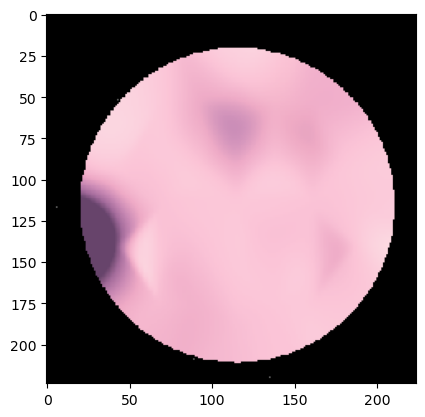

In [6]:
target_model = finetuning.Finetuning(model="AE", n_freezelayers=0)  
sample, label = target_model._input_augment_fn(dataset[28][0], dataset[0][1])
sample = torch.squeeze(sample).transpose(0,2)
# sample -= sample.min(1, keepdim=True)[0]
# sample /= sample.max(1, keepdim=True)[0]
print(sample.max())
plt.imshow(np.uint16(sample.numpy(force=True)))

# Deap Spectrogram

In [ ]:
seed = 7
# Train AE
with open("deap_spectra.pkl", "rb") as fin:
    dataset = pickle.load(fin)
    dataset = dataset['dataset']
target_model = finetuning.Finetuning(model="AE", n_freezelayers=0, seed=seed)  
sum_params = 0
for param in target_model.model.parameters():
    sum_params += torch.sum(param)
print(sum_params)

lr = 0.001
optimizer = torch.optim.Adamax(target_model.model.parameters(), lr = lr)
target_model.train(dataset, log_dir='./runs/deap/specto/AEAdamax/epoch500/seed'+str(seed), optimizer=optimizer, lr=lr, epochs=500, early_stopping_eps=0.0001, lr_decay_nepoch=100, checkpoint_path='./checkpoints/deap/specto/AEAdamax', save_every=10)
torch.save(target_model.model.state_dict(), 'AE_deap_specto_adamax_epoch500_seed'+str(seed))

In [ ]:
with open('deap_spectra.pkl', 'rb') as fin:
    dataset = pickle.load(fin)
    dataset = dataset['dataset']
target_model = finetuning.Finetuning(model="AE", n_freezelayers=0, model_params={'checkpoint': '/home/jovyan/deep-eeg/notebooks/checkpoints/deap/specto/AEAdamax/seed9/epoch_90'})  
sample, label = target_model._input_augment_fn(dataset[18][0], dataset[0][1])
print(sample.shape)
recons = target_model.model(sample.unsqueeze(0))
# recons -= recons.min(1, keepdim=True)[0]
# recons /= recons.max(1, keepdim=True)[0]
recons = torch.squeeze(recons).transpose(0,2)
# recons.shape
print(recons.max())
plt.imshow(recons.numpy(force=True))

In [ ]:
target_model = finetuning.Finetuning(model="AE", n_freezelayers=0, model_params={'checkpoint': '/home/jovyan/deep-eeg/notebooks/AE_mahnob_topomap_adamax_epoch350'})  
sample, label = target_model._input_augment_fn(dataset[18][0], dataset[0][1])
sample = torch.squeeze(sample).transpose(0,2)
# sample -= sample.min(1, keepdim=True)[0]
# sample /= sample.max(1, keepdim=True)[0]
print(sample.max())
print(sample.min())
plt.imshow(sample.numpy(force=True))

In [ ]:
with open('deap_spectra.pkl', 'rb') as fin:
    dataset = pickle.load(fin)
    dataset = dataset['dataset']
subjects = list(np.unique(dataset.sessions))
train_acc, acc, evs = per_subject_cv(dataset, subjects, lda, n_jobs=64, checkpoint='/home/jovyan/deep-eeg/notebooks/checkpoints/deap/specto/AEAdamax/seed9/epoch_90')
with open(f"result_finetune_deap_specto_AE.pkl", "wb") as fout:
    pickle.dump({"acc": acc, 
                 "train_acc": train_acc,
                 "ev": evs}, fout)

In [ ]:
with open(f"result_finetune_deap_specto_AE.pkl", "rb") as fin:
    result = pickle.load(fin)
    acc = result['acc']
    train_acc = result["train_acc"]
    evs = result["ev"]
print(acc.shape, train_acc.shape, evs.shape)
plot_overview(train_acc, acc, evs, dataset, dataset_clip=10)

# Dreamer Topomap

In [ ]:
seed = 14
ds = 'dreamer'
feat = 'topomap'
# Train AE
with open('dreamer_topomap.pkl', 'rb') as fin:
    dataset = pickle.load(fin)
    dataset = dataset['dataset']
target_model = finetuning.Finetuning(model="AE", n_freezelayers=0, seed=seed)  
sum_params = 0
for param in target_model.model.parameters():
    sum_params += torch.sum(param)
print(sum_params)

lr = 0.001
optimizer = torch.optim.Adamax(target_model.model.parameters(), lr = lr)
target_model.train(dataset, log_dir=f'./runs/{ds}/{feat}/AEAdamax/seed{seed}', optimizer=optimizer, lr=lr, epochs=500, early_stopping_eps=0.000001, lr_decay_nepoch=100, checkpoint_path=f'./checkpoints/{ds}/{feat}/AEAdamax/seed{seed}', save_every=10)
# torch.save(target_model.model.state_dict(), 'AE_dreamer_specto_adamax_epoch500_seed'+str(seed))

In [ ]:
with open('dreamer_topomap.pkl', 'rb') as fin:
    dataset = pickle.load(fin)
    dataset = dataset['dataset']
subjects = list(np.unique(dataset.sessions))
train_acc, acc, evs = per_subject_cv(dataset, subjects, lda, n_jobs=64, checkpoint='/home/jovyan/deep-eeg/notebooks/checkpoints/dreamer/topomap/AEAdamax/seed12/epoch_490')
with open(f"result_finetune_dreamer_topomap_AE_seed12_epoch490.pkl", "wb") as fout:
    pickle.dump({"acc": acc, 
                 "train_acc": train_acc,
                 "ev": evs}, fout)

In [ ]:
plot_overview(train_acc, acc, evs, dataset, dataset_clip=10)

# Dreamer Spectrogram

In [ ]:
dataset = dreamer.DreamerDataset(
    x_params={
        "feature": "SpectrogramImg",
    },
    sessions=None,
    y_mode='split',
    y_keys=['arousal'],
    seed=49,
    balanced=False,
)
subjects = list(np.unique(dataset.sessions))
with open('dreamer_spectrogram.pkl', 'wb') as fout:
    pickle.dump({'dataset': dataset}, fout)

In [ ]:
target_model = finetuning.Finetuning(model="AE", n_freezelayers=0, model_params={'checkpoint': '/home/jovyan/deep-eeg/notebooks/AE_mahnob_topomap_adamax_epoch350'})  
sample, label = target_model._input_augment_fn(dataset[8][0], dataset[0][1])
print(sample.shape)
sample = torch.squeeze(sample).transpose(0,2)
# sample -= sample.min(1, keepdim=True)[0]
# sample /= sample.max(1, keepdim=True)[0]
print(sample.max())
print(sample.min())
plt.imshow(sample.numpy(force=True))

In [ ]:
with open('dreamer_spectrogram.pkl', 'rb') as fin:
    dataset = pickle.load(fin)
    dataset = dataset['dataset']
target_model = finetuning.Finetuning(model="AE", n_freezelayers=0) 
sample, label = target_model._input_augment_fn(dataset[8][0], dataset[0][1])
print(sample.shape)
recons = target_model.model(sample.unsqueeze(0))
# recons -= recons.min(1, keepdim=True)[0]
# recons /= recons.max(1, keepdim=True)[0]
recons = torch.squeeze(recons).transpose(0,2)
# recons.shape
print(recons.max())
plt.imshow(recons.numpy(force=True))

In [ ]:
seed = 9
# Train AE
with open('dreamer_spectrogram.pkl', 'rb') as fin:
    dataset = pickle.load(fin)
    dataset = dataset['dataset']
target_model = finetuning.Finetuning(model="AE", n_freezelayers=0, seed=seed, model_params={'checkpoint': '/home/jovyan/deep-eeg/notebooks/checkpoints/dreamer/specto/AEAdamax/seed9/epoch_320'})  
sum_params = 0
for param in target_model.model.parameters():
    sum_params += torch.sum(param)
print(sum_params)

lr = 0.001
optimizer = torch.optim.Adamax(target_model.model.parameters(), lr = lr)
target_model.train(dataset, log_dir='/home/jovyan/deep-eeg/notebooks/runs/dreamer/specto/AEAdamax/seed'+str(seed), optimizer=optimizer, lr=lr, start_from=321, epochs=300, early_stopping_eps=0.000001, lr_decay_nepoch=100, checkpoint_path='./checkpoints/dreamer/specto/AEAdamax/seed'+str(seed), save_every=10)
# torch.save(target_model.model.state_dict(), 'AE_dreamer_specto_adamax_epoch800_seed'+str(seed))

In [ ]:
with open('dreamer_spectrogram.pkl', 'rb') as fin:
    dataset = pickle.load(fin)
    dataset = dataset['dataset']
subjects = list(np.unique(dataset.sessions))
torch.cuda.empty_cache()
train_acc, acc, evs = per_subject_cv(dataset, subjects, lda, n_jobs=64, checkpoint='/home/jovyan/deep-eeg/notebooks/checkpoints/dreamer/specto/AEAdamax/seed9/epoch_320')
with open(f"result_finetune_dreamer_specto_AE.pkl", "wb") as fout:
    pickle.dump({"acc": acc, 
                 "train_acc": train_acc,
                 "ev": evs}, fout)

In [ ]:
print(acc.shape, train_acc.shape, evs.shape)
plot_overview(train_acc, acc, evs, dataset, dataset_clip=10)